In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from torchsummary import summary

In [97]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [5]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [6]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [7]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [8]:
from pymono.cnn_func import ResNet10

In [9]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [11]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [12]:
crystal = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX")

In [13]:
crystal

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX'

# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 50 k photons per point (BGO, with ~9 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation
- old data format (x,y,z)

### CNN comparisons: 
- Compare basic, 3x3 and resnet

## Setup

In [14]:
files_list_npy_csv(crystal)

('images',
 'metadata',
 array([  1,   2,   3,   4,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  98,  99, 100]))

In [15]:
imgs, mdata = select_image_and_lbl(crystal, 3)

Selected files: img = images_4.npy, metdata = metadata_4.csv


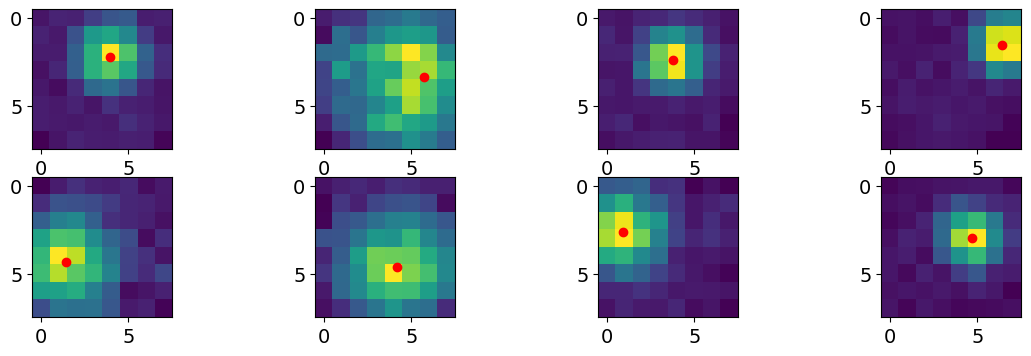

In [16]:
plot_images(imgs, mdata, range(0,8))

In [17]:
imgs[0]

array([[104., 123., 120., 160., 193., 202., 115., 118.],
       [122., 110., 188., 314., 335., 282., 156., 108.],
       [112., 112., 213., 356., 511., 390., 216., 136.],
       [ 99., 126., 211., 355., 401., 339., 199., 131.],
       [107.,  95., 131., 228., 244., 195., 127., 102.],
       [115., 110., 122., 104., 142., 119., 115., 104.],
       [114., 111., 107., 112., 110., 138., 122., 108.],
       [ 80., 104., 123., 114., 113., 118., 116.,  86.]], dtype=float32)

In [18]:
np.mean(imgs[0])

165.51562

In [19]:
np.std(imgs[0])

91.32514

In [20]:
energy = get_energy(crystal, 9)

Selected files: img = images_25.npy, metdata = metadata_25.csv


In [21]:
energy

array([10661., 10692., 10790., ..., 10512., 10462., 10714.], dtype=float32)

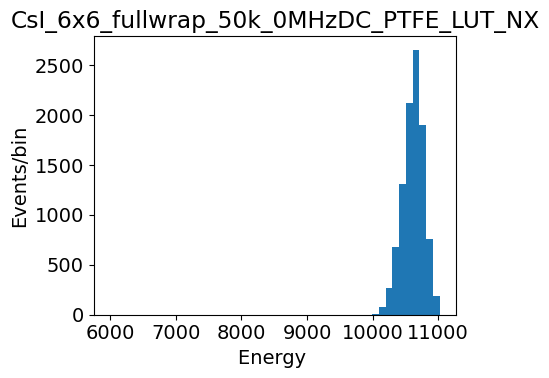

In [22]:
plot_energies2({"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX":energy}, xmin=6000, xmax=max(energy),num_bins = 50)

In [23]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 10616.38 sigma = 1.51 % FWHM = 3.47 %


## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [24]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [45]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=False)  # No comparison with energy only xyz


Running Monoataset with norm = False, resize=False, xyze=False
Loading files with indexes: [ 1  2  3  4 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [46]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 300000 events
 train size = 210000
 val size = 60000
 test size = 30000
 train indices = range(0, 210000)
 val indices = range(210000, 270000)
 test indices = range(270000, 300000)
210000 training events (70.0%)
60000 validation events (20.0%)
30000 test events (10.0%)


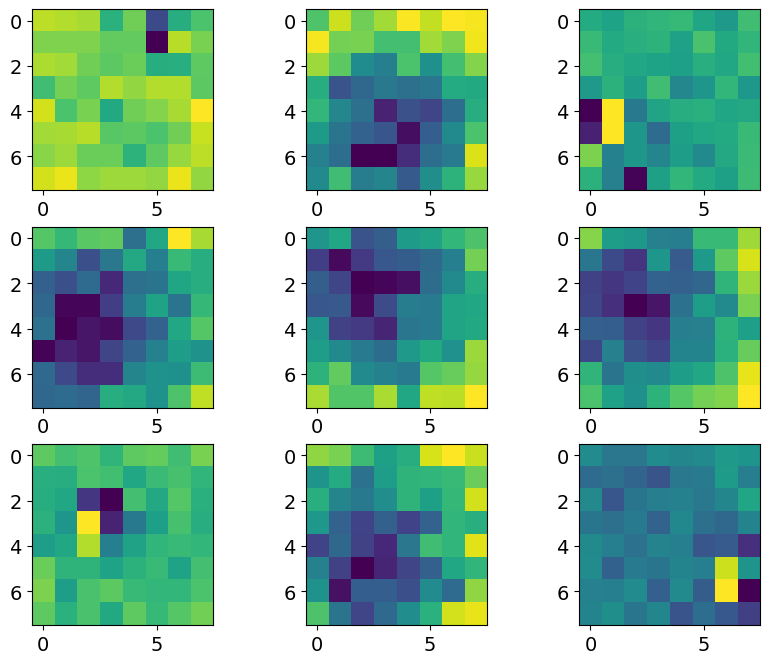

In [47]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [48]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[  91.,  108.,  117.,  106.,  120.,  119.,  135.,  109.],
        [  90.,  106.,  101.,  133.,  119.,  119.,  111.,  109.],
        [ 102.,  122.,  123.,  109.,  105.,  119.,  112.,  140.],
        [  90.,  114.,  126.,  123.,  116.,  107.,  129.,  121.],
        [ 396.,  130.,  120.,  149.,  116.,  104.,  121.,  111.],
        [1498.,  402.,  105.,  124.,  118.,  109.,  125.,  113.],
        [ 847.,  246.,  132.,  129.,  115.,  100.,  119.,  135.],
        [ 167.,  132.,  140.,  125.,  103.,  102.,  106.,  114.]])


### Define CNN

In [29]:
def image_shape_after_conv(I, P, K, S):
    """
    I: shape (1d) of input image
    P: Padding
    K: Kernel size
    S: stride
    """
    return ((I + 2*P - (K-1) -1)/S +1)
    

In [30]:
def image_evolution_cnn3x3(input, chi=64):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
    conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)
    i4 = doconv(i3, conv4, 4)

    print(f"shape of out image = {i4.shape}")
    

    


In [31]:
def image_evolution_cnn_basic(input, chi=128):
    """
    input : input image
    """

    def doconv(i, conv, nconv):
        i1 = conv(i)
        print(f"shape of image after convolution {nconv:} = {i1.shape}")
        i2 = pool(i1)
        print(f"shape of image after pool {nconv:}= {i2.shape}")
        return i2
        
    conv1 = nn.Conv2d(1, chi, 3, padding=1) # chin =1, chout=64, kernel=3x3 P=1 (S=1)
    conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
    conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
    pool  = nn.MaxPool2d(2, stride=2)  # K=2, S=2

    print(f"shape of input image = {input.shape}")

    i1 = doconv(input, conv1, 1) 
    i2 = doconv(i1, conv2, 2)
    i3 = doconv(i2, conv3, 3)

    print(f"shape of out image = {i3.shape}")

In [32]:
input = torch.randn(1, 1, 8, 8)  # batch = 1, channel=1, 8x8

In [33]:
image_evolution_cnn3x3(input, chi=64)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 1 = torch.Size([1, 64, 8, 8])
shape of image after pool 1= torch.Size([1, 64, 4, 4])
shape of image after convolution 2 = torch.Size([1, 128, 4, 4])
shape of image after pool 2= torch.Size([1, 128, 2, 2])
shape of image after convolution 3 = torch.Size([1, 256, 3, 3])
shape of image after pool 3= torch.Size([1, 256, 1, 1])
shape of image after convolution 4 = torch.Size([1, 512, 2, 2])
shape of image after pool 4= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [34]:
image_evolution_cnn_basic(input, chi=128)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 1 = torch.Size([1, 128, 8, 8])
shape of image after pool 1= torch.Size([1, 128, 4, 4])
shape of image after convolution 2 = torch.Size([1, 256, 5, 5])
shape of image after pool 2= torch.Size([1, 256, 2, 2])
shape of image after convolution 3 = torch.Size([1, 512, 3, 3])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [35]:
class CNN_basic(nn.Module):
    """
    Defines a convolutional network with a basic architecture:
    convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,128)
    convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
    convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
    drop (optional) 
    linear layer 512 => 3

    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=128, dropout=False, dropout_fraction=0.2, energy=False):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 2, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.pool = nn.MaxPool2d(2, 2)
        if energy:
            self.fc0 = nn.Linear(chi*4, 4) # add energy output.
        else:
            self.fc0 = nn.Linear(chi*4, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

 
    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
        # convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,128)
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))
        
        if(self.debug): print(f"(8,8,1) => (4,4,128) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        
        if(self.debug): print(f"(4,4,128) => (2,2,256) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        
        if(self.debug): print(f"(2,2,256) => (1,1,512) =>{x.shape}")
        x = x.flatten(start_dim=1)
        # Flatten
        
        if(self.debug): print(f"(1,1,512) => (1,1,3) =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        
        x = self.fc0(x)    # linear layer 512 => 3 (4)
        
        if(self.debug): print(x.shape)

        self.debug = False

        return x

In [36]:
class CNN_3x3(nn.Module):
    """
    Defines a convolutional network with a basic architecture:
    convolution (3x3) , reLU batch norm and MaxPool: (12,12,1) => (12,12,64)
    convolution (2x2) , reLU batch norm and MaxPool: (12,12,64) => (6,6,128)
    convolution (2x2) , reLU batch norm and MaxPool: (6,6,128) => (3,3,256)
    convolution (1x1) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
    drop (optional) 
    linear layer 512 => 3

    Input to the network are the pixels of the pictures, output (x,y,z)

    """
    def __init__(self, chi=64, dropout=False, dropout_fraction=0.2, energy=False):
        super().__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, chi, 3, padding=1) 
        self.bn1   = nn.BatchNorm2d(chi)
        self.conv2 = nn.Conv2d(chi, chi*2, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(chi*2)
        self.conv3 = nn.Conv2d(chi*2, chi*4, 2, padding=1)
        self.bn3   = nn.BatchNorm2d(chi*4)
        self.conv4 = nn.Conv2d(chi*4, chi*8, 2, padding=1)
        self.bn4   = nn.BatchNorm2d(chi*8)
        self.pool = nn.MaxPool2d(2, 2)
        if energy:
            self.fc0 = nn.Linear(chi*8, 4) # add output for energy
        else:
            self.fc0 = nn.Linear(chi*8, 3)
        self.drop1 = nn.Dropout(p=dropout_fraction)
        self.debug = True

    def forward(self, x):

        if(self.debug): print(f"input data shape =>{x.shape}")
        # convolution (3x3) , reLU batch norm and MaxPool: (8,8,1) => (4,4,64)
        if(self.debug): print(f"(8,8,1) => (4,4,64) =>{x.shape}")
        x = self.pool(self.bn1(F.leaky_relu(self.conv1(x))))

        if(self.debug): print(f"(4,4,64) => (2,2,128) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (8,8,64) => (4,4,128)
        x = self.pool(self.bn2(F.leaky_relu(self.conv2(x))))
        
        if(self.debug): print(f"(2,2,128) => (1,1,256) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (4,4,128) => (2,2,256)
        x = self.pool(self.bn3(F.leaky_relu(self.conv3(x))))
        
        if(self.debug): print(f"(1,1,256) => (1,1,512) =>{x.shape}")
        # convolution (2x2) , reLU batch norm and MaxPool: (2,2,256) => (1,1,512)
        x = self.pool(self.bn4(F.leaky_relu(self.conv4(x))))
        
        #if(self.debug): print(f"(2,2,256) => (1,1,512) =>{x.shape}")
        if(self.debug): print(f"(1,1,512) => (1,1,3) =>{x.shape}")
        x = x.flatten(start_dim=1)
        # Flatten
        
        if self.dropout: x = self.drop1(x)  # drop
        
        x = self.fc0(x)    # linear layer 512 => 3
        
        if(self.debug): print(x.shape)

        self.debug = False

        return x

In [37]:
# Load the model. Be careful to set energy to false if using conventional CNN (just positions)
model3x3 = CNN_3x3(dropout=False, energy=False).to(device)  
print(model3x3)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [38]:
summary(model3x3,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,64) =>torch.Size([2, 1, 8, 8])
(4,4,64) => (2,2,128) =>torch.Size([2, 64, 4, 4])
(2,2,128) => (1,1,256) =>torch.Size([2, 128, 2, 2])
(1,1,256) => (1,1,512) =>torch.Size([2, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512, 1, 1])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
         MaxPool2d-3             [-1, 64, 4, 4]               0
            Conv2d-4            [-1, 128, 4, 4]          73,856
       BatchNorm2d-5            [-1, 128, 4, 4]             256
         MaxPool2d-6            [-1, 128, 2, 2]               0
            Conv2d-7            [-1, 256, 3, 3]         131,328
       BatchNorm2d-8            [-1, 256, 3, 3]             512
         MaxPool2d-9            [-1, 256, 1, 

In [39]:
modelb = CNN_basic(dropout=False, energy=False).to(device)  
print(modelb)

CNN_basic(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [40]:
summary(modelb,(1,8,8))

input data shape =>torch.Size([2, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([2, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([2, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([2, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([2, 512])
torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 8, 8]           1,280
       BatchNorm2d-2            [-1, 128, 8, 8]             256
         MaxPool2d-3            [-1, 128, 4, 4]               0
            Conv2d-4            [-1, 256, 5, 5]         131,328
       BatchNorm2d-5            [-1, 256, 5, 5]             512
         MaxPool2d-6            [-1, 256, 2, 2]               0
            Conv2d-7            [-1, 512, 3, 3]         524,800
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
         MaxPool2d-9            [-1, 512, 1, 1]               0
           Linear-10              

In [41]:
# Set up the optimizer and loss function.
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)
optimizerb = optim.Adam(modelb.parameters(), lr=0.001)
criterion = nn.MSELoss()


## Cnn3x3

In [49]:
single_run(train_loader, device, model3x3, optimizer3x3,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/210, Loss: 485.9762878417969
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/210, Loss: 418.1573791503906


## Draft result (partial stats, no drop out, no norm)

In [50]:
epochs = 10

In [51]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->210000 images
size of train loader  ->210 images
Evaluating with  ->60000 images
size of eval loader  ->60 images
Running for epochs ->10

EPOCH 0
Train Step 200/210, Loss: 6.612800598144531
--- EPOCH 0 AVG TRAIN LOSS: 26.57984190895444
--- EPOCH 0 AVG VAL LOSS: 6.30367731253306

EPOCH 1
Train Step 200/210, Loss: 5.772354602813721
--- EPOCH 1 AVG TRAIN LOSS: 5.364431106476557
--- EPOCH 1 AVG VAL LOSS: 6.044434515635173

EPOCH 2
Train Step 200/210, Loss: 5.020974159240723
--- EPOCH 2 AVG TRAIN LOSS: 4.972135566529774
--- EPOCH 2 AVG VAL LOSS: 4.824782061576843

EPOCH 3
Train Step 200/210, Loss: 4.937974452972412
--- EPOCH 3 AVG TRAIN LOSS: 4.772313599359421
--- EPOCH 3 AVG VAL LOSS: 4.924808533986409

EPOCH 4
Train Step 200/210, Loss: 4.4619550704956055
--- EPOCH 4 AVG TRAIN LOSS: 4.5613496314911615
--- EPOCH 4 AVG VAL LOSS: 4.441604463259379

EPOCH 5
Train Step 200/210, Loss: 4.455503463745117
--- EPOCH 5 AVG TRAIN LOSS: 4.418927840959459
--- EPOCH 5 AVG VAL LOSS: 4.57

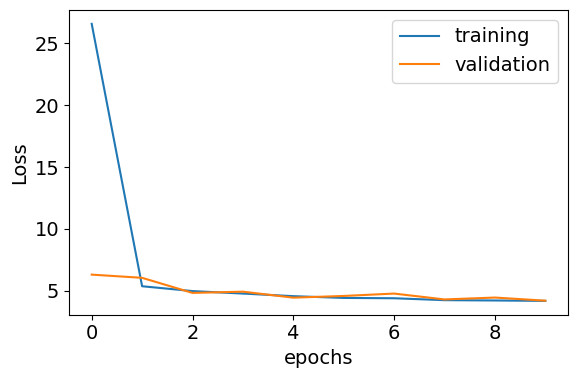

In [52]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [53]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, energy=False)

In [54]:
#plot_true_predicted(tdeltas, nbins = 50)

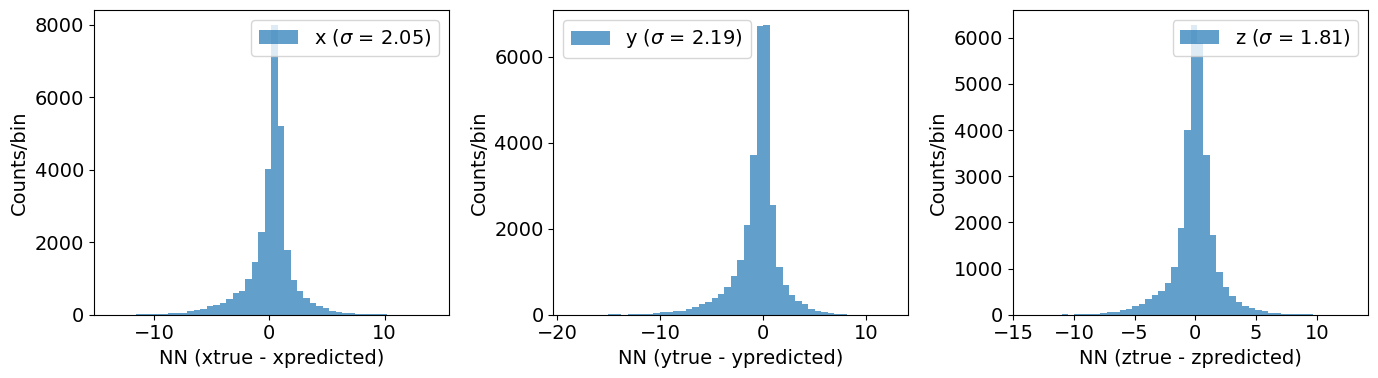

In [55]:
plotxyz(tdeltas, nbins=50)

In [42]:
#plotxyze(tdeltas, nbins=50)

## Normalization

In [56]:
means, stds = get_means_stds(dir=crystal)

files in dir: 84
shape -> (10000, 8, 8)
mean img0 =166.796875
std  img0 =382.7119445800781


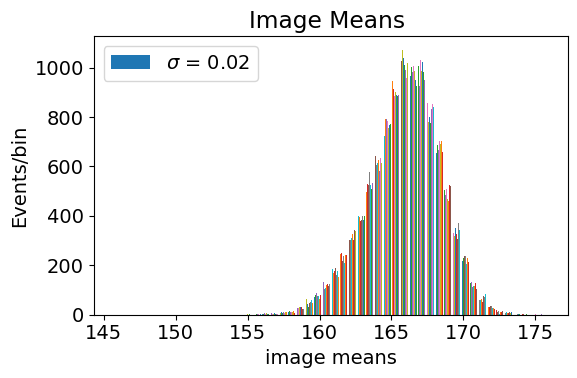

In [57]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

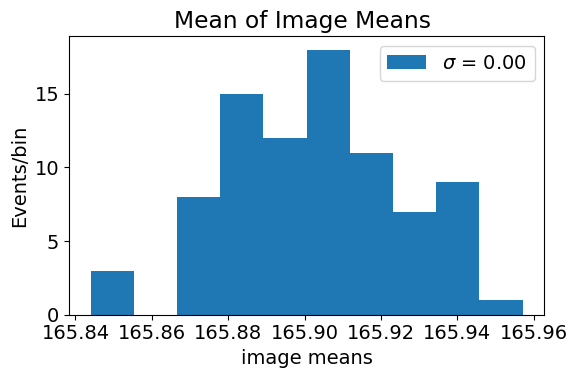

In [58]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [59]:
imean = np.mean(meansx)

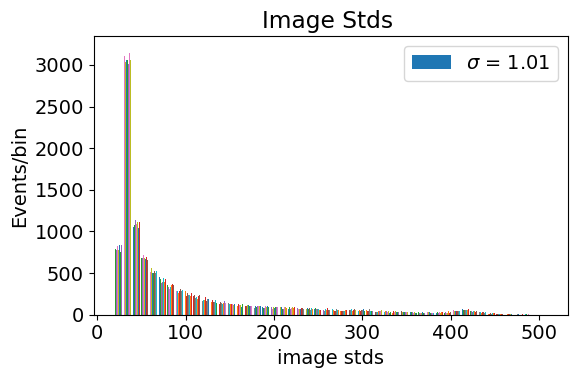

In [60]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

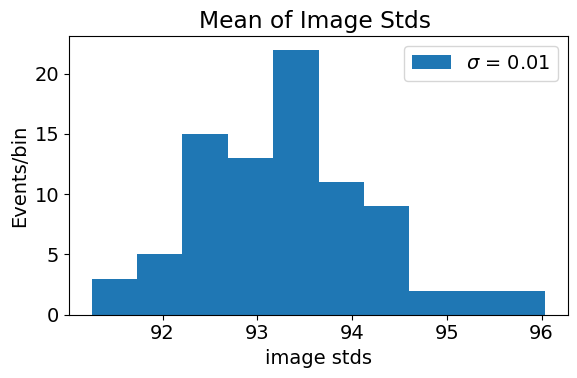

In [61]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [62]:
isigma = np.mean(stdsx)

In [63]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 165.9029541015625, std = 93.34273529052734


### Run with full stats and normalization 

In [64]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [65]:
dataset = MonoDataset(crystal, first_file, last_file, norm=True, resize=False, mean=imean, std=isigma,xyze=False)  # No comparison with energy only xyz



Running Monoataset with norm = True, resize=False, xyze=False
Loading files with indexes: [  1   2   3   4  20  21  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100]


In [66]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 840000 events
 train size = 588000
 val size = 168000
 test size = 84000
 train indices = range(0, 588000)
 val indices = range(588000, 756000)
 test indices = range(756000, 840000)
588000 training events (70.0%)
168000 validation events (20.0%)
84000 test events (10.0%)


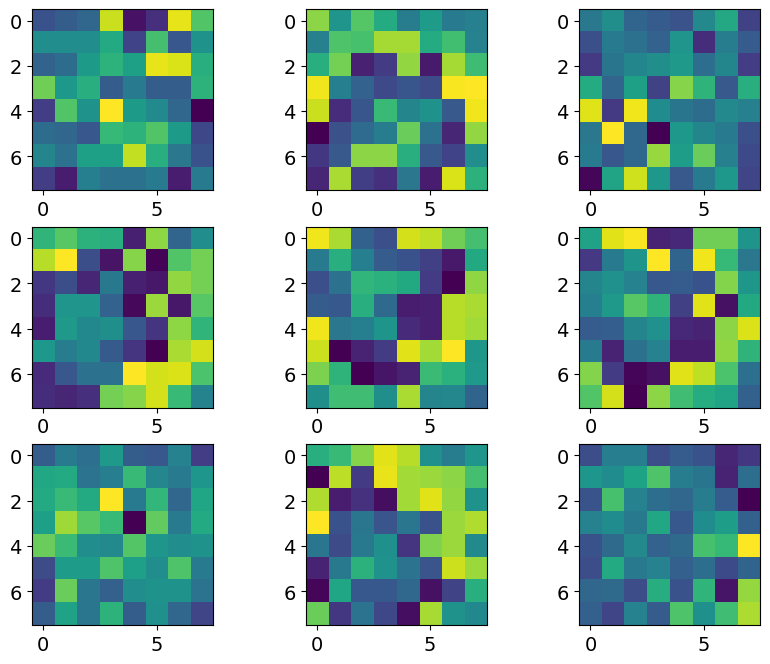

In [67]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [68]:
model3x3 = CNN_3x3(dropout=False, energy=False).to(device)
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)

In [69]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=10, iprnt=200)

Training with  ->588000 images
size of train loader  ->588 images
Evaluating with  ->168000 images
size of eval loader  ->168 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,64) =>torch.Size([1000, 1, 8, 8])
(4,4,64) => (2,2,128) =>torch.Size([1000, 64, 4, 4])
(2,2,128) => (1,1,256) =>torch.Size([1000, 128, 2, 2])
(1,1,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 200/588, Loss: 5.65527868270874
Train Step 400/588, Loss: 4.575507164001465
--- EPOCH 0 AVG TRAIN LOSS: 13.727803094046456
--- EPOCH 0 AVG VAL LOSS: 4.538284053405126

EPOCH 1
Train Step 200/588, Loss: 4.661304473876953
Train Step 400/588, Loss: 4.688419818878174
--- EPOCH 1 AVG TRAIN LOSS: 4.430634205438653
--- EPOCH 1 AVG VAL LOSS: 4.351382482619512

EPOCH 2
Train Step 200/588, Loss: 4.465011119842529
Train Step 400/588, Loss: 4.310853004455566
--- EPOCH 2 AVG TRAIN LOSS: 4.1273476

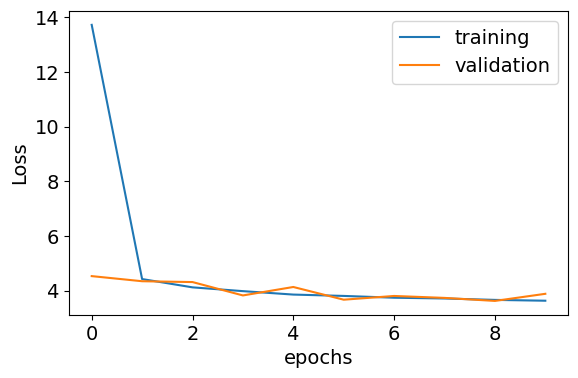

In [70]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [71]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, pixel_size = 6, energy=False)


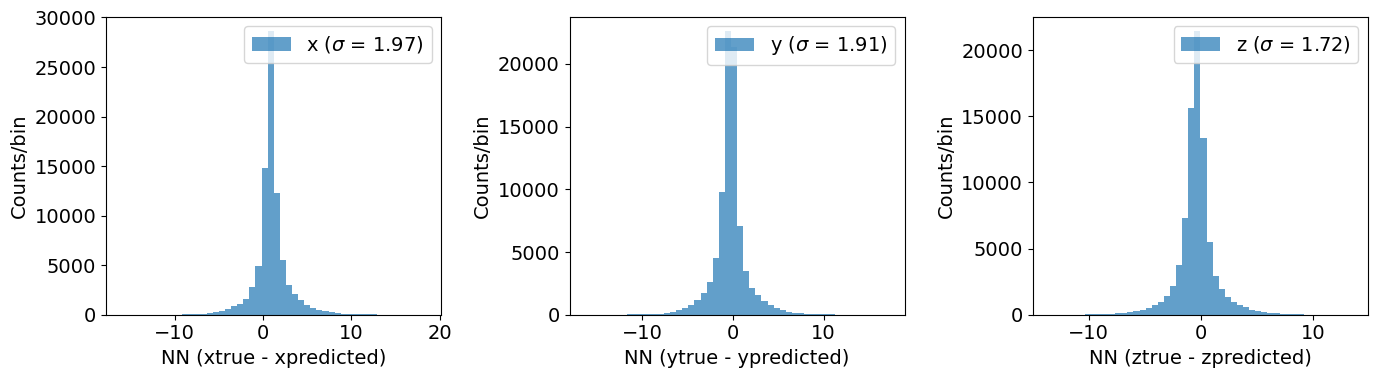

In [72]:
plotxyz(tdeltas, nbins=50)

## Repeat with dropout

In [73]:
model3x3 = CNN_3x3(dropout=True, energy=False).to(device)
optimizer3x3 = optim.Adam(model3x3.parameters(), lr=0.001)

In [74]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model3x3, optimizer3x3, device, criterion, 
                                    batch_size, epochs=10, iprnt=200)

Training with  ->588000 images
size of train loader  ->588 images
Evaluating with  ->168000 images
size of eval loader  ->168 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,64) =>torch.Size([1000, 1, 8, 8])
(4,4,64) => (2,2,128) =>torch.Size([1000, 64, 4, 4])
(2,2,128) => (1,1,256) =>torch.Size([1000, 128, 2, 2])
(1,1,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 200/588, Loss: 6.75039005279541
Train Step 400/588, Loss: 6.220384120941162
--- EPOCH 0 AVG TRAIN LOSS: 14.9011600382474
--- EPOCH 0 AVG VAL LOSS: 4.810483356316884

EPOCH 1
Train Step 200/588, Loss: 5.476506233215332
Train Step 400/588, Loss: 5.503841876983643
--- EPOCH 1 AVG TRAIN LOSS: 5.328957659857614
--- EPOCH 1 AVG VAL LOSS: 4.425935597646804

EPOCH 2
Train Step 200/588, Loss: 5.289093494415283
Train Step 400/588, Loss: 4.8798909187316895
--- EPOCH 2 AVG TRAIN LOSS: 4.98829899

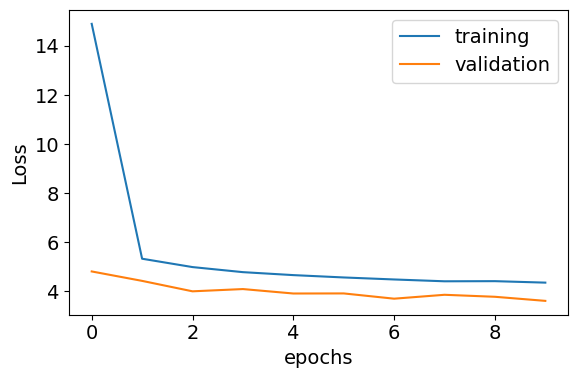

In [75]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [76]:
tdeltas = evaluate_cnn(test_loader, model3x3, device, pixel_size = 6, energy=False)


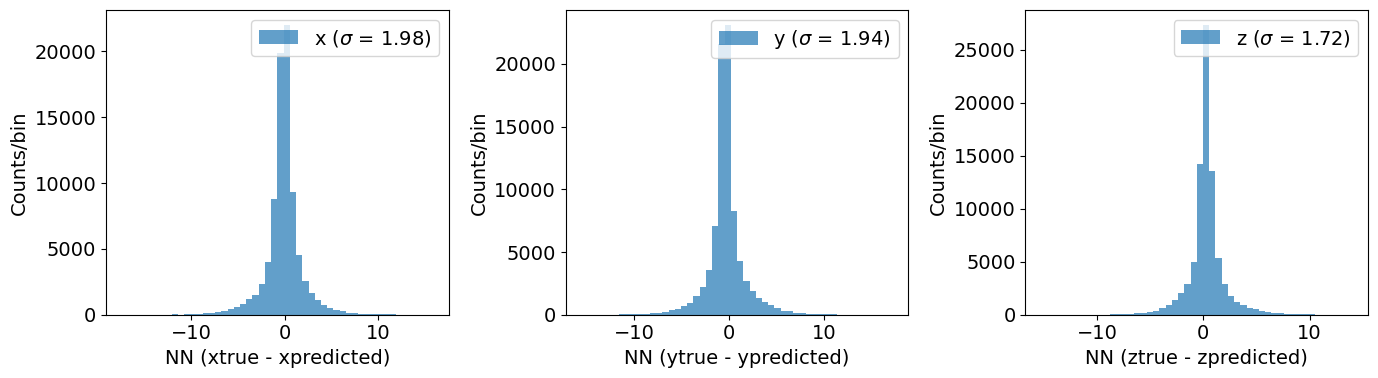

In [77]:
plotxyz(tdeltas, nbins=50)

## Basic network

In [78]:
modelb = CNN_basic(dropout=False, energy=False).to(device)  
optimizerb = optim.Adam(modelb.parameters(), lr=0.001)

In [80]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelb, optimizerb, device, criterion, 
                                    batch_size, epochs=10, iprnt=200)

Training with  ->588000 images
size of train loader  ->588 images
Evaluating with  ->168000 images
size of eval loader  ->168 images
Running for epochs ->10

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([1000, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512])
torch.Size([1000, 3])
Train Step 200/588, Loss: 5.463838577270508
Train Step 400/588, Loss: 4.67754602432251
--- EPOCH 0 AVG TRAIN LOSS: 10.758100104169781
--- EPOCH 0 AVG VAL LOSS: 4.76530323993592

EPOCH 1
Train Step 200/588, Loss: 4.701637268066406
Train Step 400/588, Loss: 4.595793724060059
--- EPOCH 1 AVG TRAIN LOSS: 4.5805197739276755
--- EPOCH 1 AVG VAL LOSS: 5.10767122961226

EPOCH 2
Train Step 200/588, Loss: 4.408681392669678
Train Step 400/588, Loss: 3.8045120239257812
--- EPOCH 2 AVG TRAIN LOSS: 4.298127990596148
--- EPOCH 2 AVG VAL LOSS: 4.328201022886095

EP

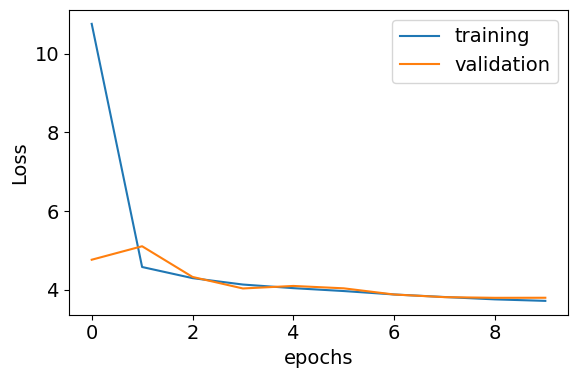

In [81]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

In [82]:
tdeltas = evaluate_cnn(test_loader, modelb, device, pixel_size = 6, energy=False)

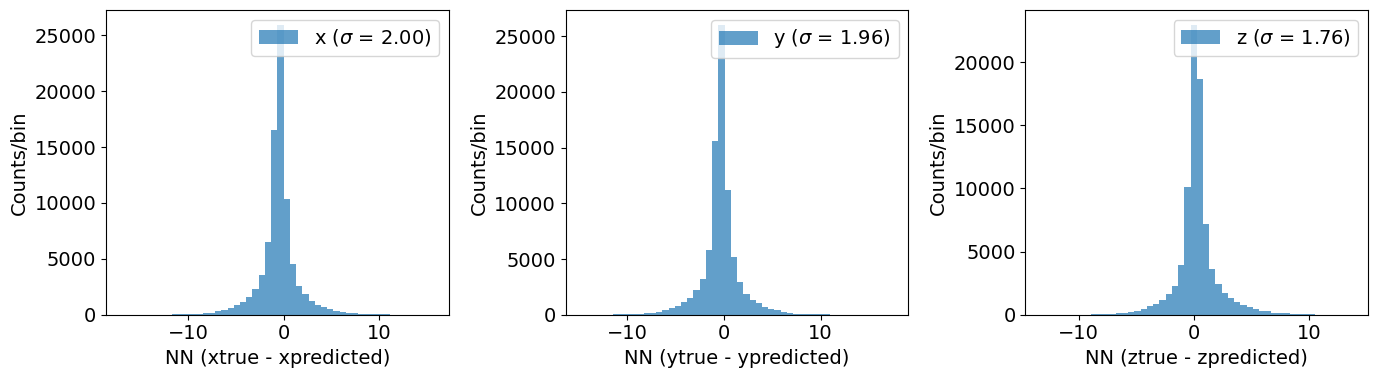

In [83]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [84]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [85]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [86]:
#define the model
modelrn = ResNet10(ResBlock, debug=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [87]:
summary(modelrn,(1,8,8))

 ResNet10: input data shape =>torch.Size([2, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([2, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([2, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([2, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([2, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([2, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([2, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([2, 512])
 ResNet10: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [88]:
optimizerrn = optim.Adam(modelrn.parameters(), lr=0.001)

In [90]:
single_run(train_loader, device, modelrn, optimizerrn,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/588, Loss: 478.3209228515625
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/588, Loss: 421.1112365722656


In [91]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelrn, optimizerrn, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

Training with  ->294000 images
size of train loader  ->588 images
Evaluating with  ->84000 images
size of eval loader  ->168 images
Running for epochs ->10

EPOCH 0
Train Step 200/588, Loss: 5.041243553161621
Train Step 400/588, Loss: 4.788311958312988
--- EPOCH 0 AVG TRAIN LOSS: 16.215723148819542
--- EPOCH 0 AVG VAL LOSS: 4.488347223826817

EPOCH 1
Train Step 200/588, Loss: 4.221582412719727
Train Step 400/588, Loss: 4.005686283111572
--- EPOCH 1 AVG TRAIN LOSS: 4.133190714583105
--- EPOCH 1 AVG VAL LOSS: 3.796128592320851

EPOCH 2
Train Step 200/588, Loss: 3.915728807449341
Train Step 400/588, Loss: 3.817009687423706
--- EPOCH 2 AVG TRAIN LOSS: 3.8698801560466793
--- EPOCH 2 AVG VAL LOSS: 3.7115883983316875

EPOCH 3
Train Step 200/588, Loss: 4.31193208694458
Train Step 400/588, Loss: 3.3187148571014404
--- EPOCH 3 AVG TRAIN LOSS: 3.764056524046424
--- EPOCH 3 AVG VAL LOSS: 3.7080588255609785

EPOCH 4
Train Step 200/588, Loss: 3.824509620666504
Train Step 400/588, Loss: 3.90797519683

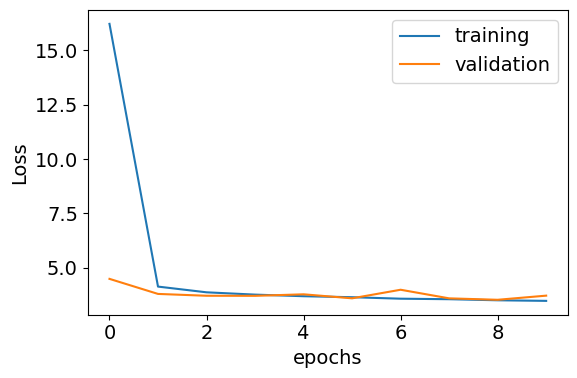

In [92]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))



In [93]:
tdeltas = evaluate_cnn(test_loader, modelrn, device, pixel_size = 6, energy=False)

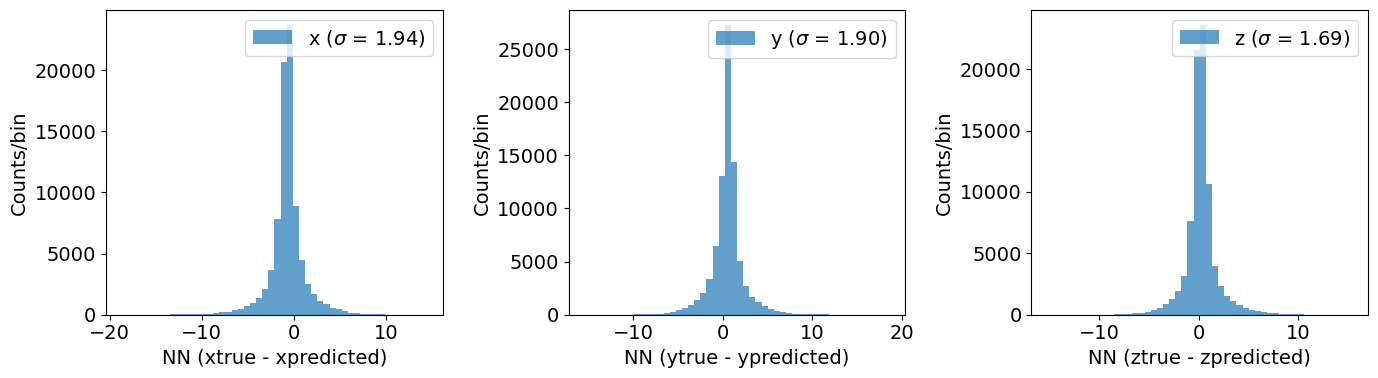

In [94]:
plotxyz(tdeltas, nbins=50)

## Fit data

In [106]:
def bin_centers(bins):
    return np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])
def weighted_error(sigma1, w1, sigma2, w2):
    return sigma1 * w1 + sigma2 * w2

In [98]:
def fit_dgaussian(xdata, 
                  ydata, 
                  pars=[10000., 0.5, 2.0, 10000., 0.5, 2.0],
                  lower_bounds = [0, -1.0, 0.0, 0.0, -1.0, 0.0],
                  upper_bounds = [100000, 1.0, 15.0, 100000.0, 1.0, 15.0]
                 ):

    def gaussian(x, a1, mu1, sigma1, a2, mu2, sigma2):
        g1 = a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
        g2 = a2*(np.exp(-(x-mu2)**2/(2*sigma2**2)))
        return g1 + g2
    
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars, 
                          bounds=(lower_bounds, upper_bounds))
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 

In [101]:
def fit_coord(tdeltas, bins=100):
    def bin_data(data, bins):
        hdz, binsz = np.histogram(data, bins=bins)
        xdata = bin_centers(binsz)
        ydata = hdz
        return xdata, ydata

    def fitcoord2g(data, bins):
        xdata, ydata = bin_data(data, bins)
        pars, err, yfit = fit_dgaussian(xdata, ydata)
        n1 = pars[0]/(pars[0]+ pars[3])
        n2 = pars[3]/(pars[0]+ pars[3])
        we = weighted_error(pars[2], n1, pars[5], n2)
        print(f"2g fit: mu1 = {pars[1]:.2f}, sigma = {pars[2]:.2f}, n1  ={n1:.2f}")
        print(f"2g fit: mu2 = {pars[4]:.2f}, sigma = {pars[5]:.2f}, n1  ={n2:.2f}")
        print(f"weighted error: = {we:.2f}")
    
        fit2g = namedtuple('fit2g',
               'xdata, ydata, yfit, norms, mus, sigmas')
        return fit2g(xdata, ydata, yfit, 
                    (pars[0], pars[3]), (pars[1], pars[4]), (pars[2], pars[5]))
        
    f2gz = fitcoord2g(tdeltas.delta_z_NN, bins=bins)
    f2gx = fitcoord2g(tdeltas.delta_x_NN, bins=bins)
    f2gy = fitcoord2g(tdeltas.delta_y_NN, bins=bins)
    
    return f2gz, f2gx, f2gy

In [109]:
def plotfxyz(f2gx, f2gy, f2gz, figsize=(8, 6)):
    def n1n2(norms):
        n1 = norms[0]/(norms[0]+ norms[1])
        n2 = norms[1]/(norms[0]+ norms[1])
        return n1, n2
        
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    flat_axes = axes.ravel()
    ax0, ax1, ax2 = flat_axes[0], flat_axes[1], flat_axes[2]

    n1, n2 = n1n2(f2gx.norms)
    ax0.errorbar(f2gx.xdata, f2gx.ydata,yerr=np.sqrt(f2gx.ydata), fmt='o', markersize=2)
    ax0.plot(f2gx.xdata, f2gx.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gx.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gx.sigmas[1]:.2f}")
    ax0.legend()
    ax0.set_xlabel("NN (xtrue - xpredicted)",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    
    n1, n2 = n1n2(f2gy.norms)
    ax1.errorbar(f2gy.xdata, f2gy.ydata,yerr=np.sqrt(f2gy.ydata), fmt='o', markersize=2)
    ax1.plot(f2gy.xdata, f2gy.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gy.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gy.sigmas[1]:.2f}")
    ax1.legend()
    ax1.set_xlabel("NN (ytrue - ypredicted)",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)

    n1, n2 = n1n2(f2gz.norms)
    ax2.errorbar(f2gz.xdata, f2gz.ydata,yerr=np.sqrt(f2gz.ydata), fmt='o', markersize=2)
    ax2.plot(f2gz.xdata, f2gz.yfit, 'red', linewidth=1.0,
                label=f"$\sigma_1$(i={n1:.2f}) = {f2gz.sigmas[0]:.2f}\n $\sigma_2$(i={n2:.2f}) = {f2gz.sigmas[1]:.2f}")
    ax2.legend()
    ax2.set_xlabel("NN (ztrue - zpredicted)",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)

    fig.tight_layout()
    plt.show()

In [102]:
tdeltas

tdeltas(delta_x_NN=array([ 3.7174711 , -2.769989  , -4.9733553 , ..., -0.5715637 ,
       -1.0121186 , -0.47177124], dtype=float32), delta_y_NN=array([ 3.5224643 ,  1.607357  , -1.6419921 , ...,  1.3191018 ,
        0.56992984,  0.54752636], dtype=float32), delta_z_NN=array([-11.057819  ,   1.0232506 ,   2.8773918 , ...,  -0.17271805,
         0.84165955,  -0.8820038 ], dtype=float32), delta_x_classical=0.0, delta_y_classical=0.0)

In [107]:
f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)

2g fit: mu1 = 0.17, sigma = 0.54, n1  =0.87
2g fit: mu2 = 0.33, sigma = 2.16, n1  =0.13
weighted error: = 0.76
2g fit: mu1 = -0.67, sigma = 1.83, n1  =0.22
2g fit: mu2 = -0.74, sigma = 0.46, n1  =0.78
weighted error: = 0.77
2g fit: mu1 = 0.67, sigma = 0.42, n1  =0.74
2g fit: mu2 = 0.37, sigma = 1.64, n1  =0.26
weighted error: = 0.74


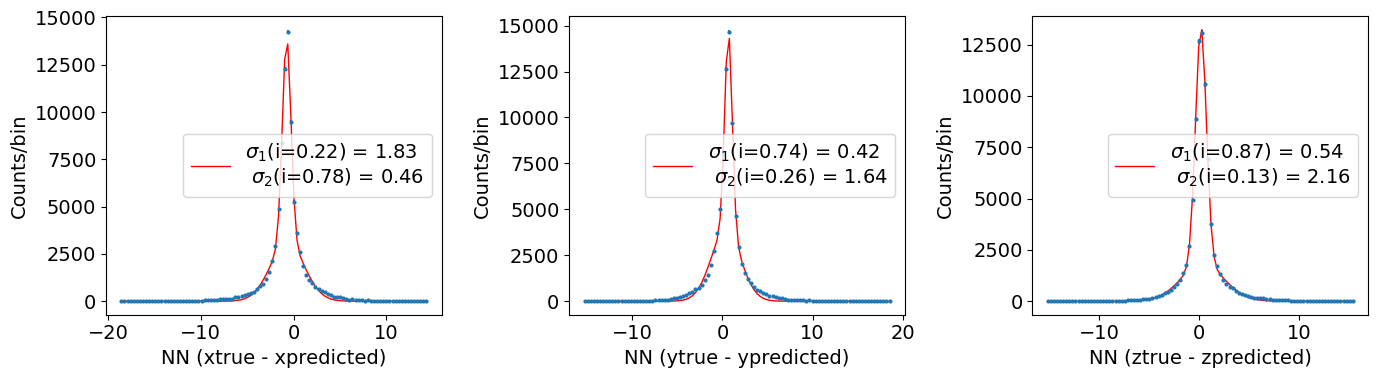

In [114]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))